# Train a Simplicial Complex Net (SCoNe)

In this notebook, we will create and train a SCoNe neural network in the simplicial complex domain, as proposed in the paper by [Roddenberry et. al : Principled Simplicial Neural Networks for Trajectory Prediction (2021)](http://proceedings.mlr.press/v139/roddenberry21a/roddenberry21a.pdf). 

The equations of one layer of this neural network are given by:

🟥 $\quad m^{(1 \rightarrow 0 \rightarrow 1)}_{y \rightarrow \{z\} \rightarrow x}  = (L_{\downarrow,1})\_{xy} \cdot h_y^{t,(1)} \cdot \Theta^{t,(1 \rightarrow 0 \rightarrow 1)}$

🟥 $\quad m_{x \rightarrow x}^{(1 \rightarrow 1)}  = h_x^{t,(1)} \cdot \Theta^{t,(1 \rightarrow 1)}$

🟥 $\quad m_{y \rightarrow \{z\} \rightarrow x}^{(1 \rightarrow 2 \rightarrow 1)}  = (L_{\uparrow,1})\_{xy} \cdot h_y^{t,(1)} \cdot \Theta^{t,(1 \rightarrow 2 \rightarrow 1)}$

🟧 $\quad m_{x}^{(1 \rightarrow 0 \rightarrow 1)} = \sum_{y \in \mathcal{L}\_\downarrow(x)} m_{y \rightarrow \{z\} \rightarrow x}^{(1 \rightarrow 0 \rightarrow 1)}$

🟧 $\quad m_{x}^{(1 \rightarrow 2 \rightarrow 1)}  = \sum_{y \in \mathcal{L}\_\uparrow(x)} m_{y \rightarrow \{z\} \rightarrow x}^{(1 \rightarrow 2 \rightarrow 1)}$

🟩 $\quad m_x^{(1)}  = m_{x}^{(1 \rightarrow 0 \rightarrow 1)} + m_{x \rightarrow x}^{(1 \rightarrow 1)} + m_{x}^{(1 \rightarrow 2 \rightarrow 1)}$

🟦 $\quad h_x^{t,(1)} = \sigma(m_x^{(1)})$

Where the notations are defined in [Papillon et al : Architectures of Topological Deep Learning: A Survey of Topological Neural Networks (2023)](https://arxiv.org/abs/2304.10031).

We generate a synthetic dataset consisting of trajectories on a simplicial complex, and perform trajectory prediction on this dataset using SCoNe.


In [1]:
import random
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import toponetx as tnx
import networkx as nx
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm
from scipy.spatial import Delaunay, distance

import sys

sys.path.append("../../")
from topomodelx.nn.simplicial.scone_layer import SCoNeLayer

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Generating the dataset

We, more or less, follow the method proposed in the original paper. The dataset will consist of trajectories (1-chains) on a fixed simplicial complex of dimension 2.

## Generating the simplicial complex ##

First, we generate a simplicial complex as follows:

1. Uniformly sample $n$ points $P$ in the unit square $[0,1]^2$.
2. Construct the Delaunay triangulation $K$ of $P$.
3. Remove all 2-simplices having its centroid contained in any of two pre-defined disks. This creates holes in the triangulation, making the topology more interesting.

We will visualise the simplicial complex obtained this way later. One can easily modify the generating function to construct different complexes, for example, by adding more holes.

In [3]:
def generate_complex(N: int = 100) -> tuple[tnx.SimplicialComplex, np.ndarray]:
    """
    This function generates a simplicial complex of dimension 2 as follows:
        1. Uniformly sample N random points form the unit square and build the Delaunay triangulation.
        2. Delete triangles contained in some pre-defined disks.
    """
    points = np.random.uniform(0, 1, size=(N, 2))

    # Sort points by the sum of their coordinates
    c = np.sum(points, axis=1)
    order = np.argsort(c)
    points = points[order]

    tri = Delaunay(points)  # Create Delaunay triangulation
    # Remove triangles having centroid inside the disks
    disk_centers = np.array([[0.3, 0.7], [0.7, 0.3]])
    disk_radius = 0.15
    simplices = []
    indices_included = set()
    for simplex in tri.simplices:
        center = np.mean(points[simplex], axis=0)
        if ~np.any(distance.cdist([center], disk_centers) <= disk_radius, axis=1):
            simplices.append(simplex)
            indices_included |= set(simplex)

    # Re-index points in simplices before constructing a simplicial complex
    idx_dict = {i: j for j, i in enumerate(indices_included)}
    for i in range(len(simplices)):
        for j in range(3):
            simplices[i][j] = idx_dict[simplices[i][j]]

    sc = tnx.SimplicialComplex(simplices)
    coords = points[list(indices_included)]
    return sc, coords

We can now generate a simplicial complex based on 150 randomly sampled points as follows:

In [4]:
# Generate simplicial complex
n = 150
sc, coords = generate_complex(n)

Here, `sc` is an instance of the `SimplicialComplex` class from `TopoNetX`, and `coords` contains the Euclidean coordinates of the vertices. We will use the coordinates to construct trajectories on the simplicial complex next.

## Generating trajectories ##

We now randomly pick triplets $(s,m,e)$ where 
- $s$ is sampled from the lower left corner, 
- $m$ is sampled from around the middle anti-diagonal and 
- $e$ is sampled from the upper right corner. 

We then compute the shortest paths from $s$ to $m$ and from $m$ to $e$, respectively. We then concatenate these two paths to form a single path from $s$ to $e$. Our dataset consists of the collections of such paths.

The parameter `n_max` determines the maximum number of trajectories to generate.

In [5]:
def generate_trajectories(
    sc: tnx.SimplicialComplex, coords: np.ndarray, n_max: int = 1000
) -> list[list[int]]:
    """
    Generate trajectories from nodes in the lower left corner to the upper right corner connected through a node in the middle.
    """
    # Get indices for start points in the lower left corner, mid points in the center region and end points in the upper right corner.
    N = len(sc)
    start_nodes = list(range(0, int(0.2 * N)))
    mid_nodes = list(range(int(0.4 * N), int(0.5 * N)))
    end_nodes = list(range(int(0.8 * N), N))
    all_triplets = list(product(start_nodes, mid_nodes, end_nodes))

    assert (
        len(all_triplets) >= n_max
    ), f"Only {len(all_triplets)} valid paths, but {n_max} requested. Try increasing the number of points in the simplicial complex."
    triplets = random.sample(all_triplets, n_max)

    # Compute pairwise distances and create a matrix representing the underlying graph.
    distance_matrix = distance.squareform(distance.pdist(coords))
    graph = sc.adjacency_matrix(0).toarray() * distance_matrix
    G = nx.from_numpy_array(graph)

    # Find shortest paths
    paths = []
    for s, m, e in triplets:
        path_1 = nx.shortest_path(G, s, m, weight="weight")
        path_2 = nx.shortest_path(G, m, e, weight="weight")
        path = path_1[:-1] + path_2
        paths.append(path)

    return paths

We now generate our entire set of trajectories which we will later use for training and evaluating the trajectory prediction model.

In [6]:
# Generate trajectories for training and evaluation
trajectories = generate_trajectories(sc, coords, 1200)

## Visualising the simplicial complex and trajectories ##

We create two helper functions for visualising the simplicial complex and trajectories on it, respectively.

In [7]:
def plot_complex(sc: tnx.SimplicialComplex, coords: np.ndarray) -> None:
    """
    Given a simplicial complex of dimension 1 or 2, plot the simplices in the plane using the coordinates of the 0-simplices in coords.
    """
    # Plot triangles
    for idx in sc.skeleton(2):
        pts = np.array([coords[idx[0]], coords[idx[1]], coords[idx[2]]])
        poly = plt.Polygon(pts, color="green", alpha=0.25)
        plt.gca().add_patch(poly)

    # Plot edges
    start = coords[np.array(sc.skeleton(1))[:, 0]]
    end = coords[np.array(sc.skeleton(1))[:, 1]]
    plt.plot(
        np.vstack([start[:, 0], end[:, 0]]),
        np.vstack([start[:, 1], end[:, 1]]),
        color="black",
        alpha=0.5,
    )

    # Plot points
    plt.scatter(coords[:, 0], coords[:, 1], color="black", s=30)


def plot_path(path: list[int], coords: np.ndarray) -> None:
    """
    Plot red arrows representing a trajectory.
    """
    x, y = coords[path, 0], coords[path, 1]
    plt.quiver(
        x[:-1],
        y[:-1],
        x[1:] - x[:-1],
        y[1:] - y[:-1],
        scale_units="xy",
        angles="xy",
        scale=1,
        color="red",
    )

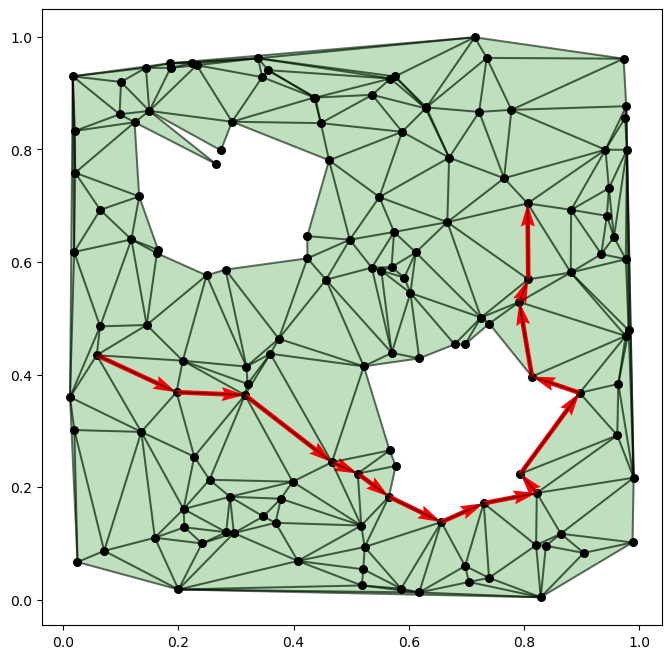

In [8]:
plot_complex(sc, coords)
plot_path(trajectories[0], coords)

## Creating PyTorch dataloaders ##

Since we are going to train a neural network to predict the next node in a trajectory, we create a custom PyTorch dataset. The dataset contains triplets of the following type:

1. A vector representation of the trajectory (with the last edge removed),
2. a mask encoding the neighbours of the second to last vertex, and
3. the last vertex in the original trajectory, i.e., the ground truth label.

Let $\mathcal{E}=\{e_1, e_2,\ldots, e_m\}$ denote the set of edges in the simplicial complex and let $T=(i_1, i_2,\ldots, i_k)$ be a trajectory. The *vectorization of $T$* is the vector $(a_1, a_2, \ldots, a_m)$ where we set 
1. $a_j=+1$ if $(i_j, i_{j+1})\in\mathcal{E}$,
2. $a_j=-1$ if $(i_{j+1}, i_j)\in\mathcal{E}$ and
3. $a_j=0$ otherwise.

The neighbourhood mask is used later in the forward pass of our model when we want to do softmax, but only over the neighbours of $i_{k-1}$.

In [9]:
class TrajectoriesDataset(Dataset):
    def __init__(
        self, sc: tnx.SimplicialComplex, trajectories: list[list[int]]
    ) -> None:
        self.trajectories = trajectories
        self.sc = sc
        self.adjacency = torch.Tensor(sc.adjacency_matrix(0).toarray())

        # Lookup table used to speed up vectorizing of trajectories
        self.edge_lookup_table = {}
        for i, edge in enumerate(self.sc.skeleton(1)):
            self.edge_lookup_table[edge] = (1, i)
            self.edge_lookup_table[edge[::-1]] = (-1, i)

    def __getitem__(
        self, index: int
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        trajectory = self.trajectories[index]
        vectorized_trajectory = self.vectorize_path(
            trajectory[:-1]
        )  # Discard the last node

        # Find neighbours of the last node in the trajectory (for use in the forward pass of SCoNe)
        neighbours_mask = (
            torch.Tensor(self.adjacency[trajectory[-2]] > 0).float().unsqueeze(-1)
        )

        last_node = torch.tensor(trajectory[-1])

        return vectorized_trajectory, neighbours_mask, last_node

    def __len__(self) -> int:
        return len(self.trajectories)

    def vectorize_path(self, path: list[int]) -> torch.Tensor:
        # Create a vector representation of a trajectory.
        m = len(self.sc.skeleton(1))
        c0 = torch.zeros((m, 1))
        for j in range(0, len(path) - 1):
            edge = (path[j], path[j + 1])
            sign, i = self.edge_lookup_table[edge]
            c0[i] = sign
        return c0

Using the above dataset class, we split the data (60/20/20) and create data loaders for our training, validation and test data, respectively.

In [10]:
dataset = TrajectoriesDataset(sc, trajectories)

batch_size = 32
test = 0.2
val = 0.2
val_size = int(val * len(dataset))
test_size = int(test * len(dataset))
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# Creating the Neural Network

We are now ready to define the trajectory prediction network using the `SCoNeLayer` class. We stack multiple SCoNe layers and apply the softmax operator on the neighbours of the last vertex. The first and last layers have feature dimensions $1$. The other hidden dimensions are given by a list of integers.

In [11]:
class SCoNe(nn.Module):
    def __init__(self, sc: tnx.SimplicialComplex, hidden_dims: list[int]) -> None:
        super().__init__()
        self.incidence_1 = torch.Tensor(sc.incidence_matrix(1).toarray())
        self.incidence_2 = torch.Tensor(sc.incidence_matrix(2).toarray())
        self.adjacency = torch.Tensor(sc.adjacency_matrix(0).toarray())

        self.weights = nn.parameter.Parameter(torch.Tensor(hidden_dims[-1], 1))
        nn.init.xavier_uniform_(self.weights)

        self.hidden_dimensions = hidden_dims
        self.L = len(hidden_dims)

        # Stack multiple SCoNe layers with given hidden dimensions
        self.layers = nn.ModuleList([SCoNeLayer(1, hidden_dims[0])])
        for i in range(self.L - 1):
            self.layers.append(SCoNeLayer(hidden_dims[i], hidden_dims[i + 1]))

        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, self.incidence_1, self.incidence_2)
        x = self.incidence_1 @ x @ self.weights
        # Set prediction of non-neighbours to approximately -inf since we are applying softmax in the loss function
        x = x + (1e-15 + mask).log()
        return nn.functional.log_softmax(x, dim=1)

# Training the Neural Network

We will train the network for 25 epochs using the Adam optimizer with hyperparameters given below. We choose a network with 5 hidden layers, each with dimension 16.

In [12]:
epochs = 25
lr = 1e-3
weight_decay = 5e-5
betas = (0.9, 0.99)
hidden_dims = [16, 16, 16, 16, 16]

model = SCoNe(sc, hidden_dims)
loss_function = nn.NLLLoss()
optimizer = Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

training_history = {"train_loss": [], "train_acc": [], "val_acc": []}

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1:02}/{epochs:02}")

    # Training step
    training_losses = []
    training_accuracies = []
    model.train()
    for batch in train_dl:
        traj, mask, last_nodes = batch
        optimizer.zero_grad()
        outputs = model(traj, mask)
        loss = loss_function(outputs, last_nodes.unsqueeze(-1))
        preds = torch.argmax(outputs, dim=1).squeeze()
        accuracy = torch.sum(preds == last_nodes) / preds.shape[0]
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        training_accuracies.append(accuracy.item())

    training_history["train_loss"].append(np.mean(training_losses))
    training_history["train_acc"].append(np.mean(training_accuracies))

    # Validation step
    model.eval()
    correct = 0
    for batch in val_dl:
        traj, mask, last_nodes = batch
        outputs = model(traj, mask)
        preds = torch.argmax(outputs, dim=1).squeeze()
        correct += torch.sum(preds == last_nodes)
    training_history["val_acc"].append(correct / len(val_ds))

Epoch 01/25
Epoch 02/25
Epoch 03/25
Epoch 04/25
Epoch 05/25
Epoch 06/25
Epoch 07/25
Epoch 08/25
Epoch 09/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25


We plot the training loss and the accuracies obtained on the training and validation data.

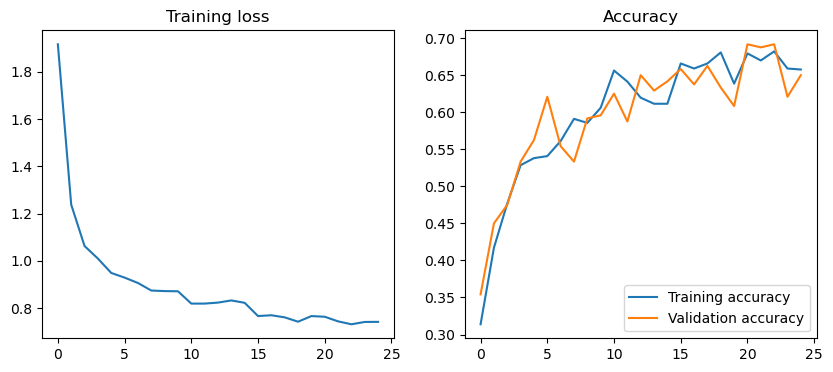

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
axes[0].set_title("Training loss")
axes[0].plot(training_history["train_loss"])
axes[1].set_title("Accuracy")
axes[1].plot(training_history["train_acc"], label="Training accuracy")
axes[1].plot(training_history["val_acc"], label="Validation accuracy")
axes[1].legend()
plt.show()

# Evaluating the model on test data

We can now evaluate the trained model on our test data. The average number of neighbours in our simplicial complex is approximately 5.5, meaning that accuracies above 0.19 are better than random guessing.

In [14]:
model.eval()
correct = 0
for batch in test_dl:
    traj, mask, last_nodes = batch
    outputs = model(traj, mask)
    preds = torch.argmax(outputs, dim=1).squeeze()
    correct += torch.sum(preds == last_nodes)

print(f"Test accuracy: {correct / len(test_ds):.3f}")

Test accuracy: 0.688
